# Initiez-vous au MLOps (partie 1/2)
## Option B - Exercice - Élaborez un modèle de scoring

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
 
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

La mission :
- Construire et optimiser un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.
- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à la pré-production du modèle.

Mise en oeuvre des étapes orientées MLOps suivantes :
- Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations.
- Lancer l’interface web “UI MLFlow" d'affichage des résultats du tracking.
- Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”.
- Tester le serving MLFlow.

### Objectif de cette étape :
* Un ou plusieurs modèles entraînés, avec validation croisée et premières métriques d’évaluation.
#### A faire :
* Commencer par tester des modèles simples (Logistic Regression, Random Forest).
* Comparer ensuite avec des modèles plus puissants (XGBoost, LightGBM).
* UtiliserStratifiedKFoldpour conserver la distribution de classes et pour garantir une évaluation robuste.
* Entraîner les modèles dans des notebooks clairs et documentés.
* Stocker les scores et les hyperparamètres testés.
#### Utilisation des métriques suivantes :
* AUC-ROC
* Recall sur la classe minoritaire
* F1-score
* Coût métier personnalisé (FN > FP)
#### Réalisation :
**L'ensemble des étapes est suivi et enregistré sur un MLFLow en local**
1) Séparation du jeu et création de la fonction de preprocessing et pipeline
2) Mise en place de la recherche d'hyperparamètres via GridSearchCV
    * Logistic Regression
    * Random Forest
    * XGBoost
    * LightGBM
    * Chaque modèle est enregistrée dans un run différent afin de comparer les scores de la métrique principale AUC
    * Etant donné le long traitement des modèles, nous avons utilisé que class weight pour gérer les déséquilibres, 
    en appliquant "balanced" quand c'était possible sans chercher d'autres combinaisons de class weight.
    * Dans la compréhension des résultats, mise en avant de l'importance de la métrique recall de la classe 1 afin de prendre le + possible de "mauvais payeurs'.
3) Validation croisée avec les meilleurs paramètres sur l'ensemble des modèles
    * cross_validate couplé avec cross_validate_predict pour observer les résultats des métriques suivantes par modèle :
        * roc_auc
        * precision
        * recall
        * f1
        * average_precision
        * balanced_accuracy
    * Calcul du seuil métier : avec un coût métier de l'ordre de 10 par FN et 1 par FP
    * Graphique de la courbe ROC-AUC
    * Graphique de comparaison du seuil métier versus le seuil de base (0.5)
    * Enregistrement des résultats sous MLFlow dans un autre run mais dans une version 2 de chaque model dans model registry
4) Version des résultats du modèle avec le seuil métier comme référence
    * Enregistrement des résultats sous MLFlow dans un autre run mais dans une version 3 de chaque model dans model registry
5) Comparaison du meilleur modèle sous MLFlow
6) Vérification de cohérence avec les consignes, aucun des scores AUC ne dépassent 0.82, ils se situent entre 0.75 & 0.78

### Importation des librairies

In [24]:
# Librairies de base
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour sauvegarde
import joblib
import os

# Ajout de MlFlow
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri("file://" + os.path.abspath("../mlruns"))
from mlflow.tracking import MlflowClient

# Libraires scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split,GridSearchCV, cross_validate,cross_val_predict, StratifiedKFold)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neural_network import MLPClassifier
from mlflow.models import infer_signature
from sklearn.metrics import roc_curve, roc_auc_score

from xgboost import XGBClassifier
import lightgbm as lgb

# Meilleure visualisation des grands df
import itables.options as opt
from itables import show

# Activation de l’affichage interactif automatiquement dans les notebooks
opt.warn_on_undocumented_option = False
opt.notebook_connected = True
opt.maxBytes = 0 # Pour ne pas tronquer les gros DataFrames
opt.maxColumns = 0

### Chargement du dataset fusionné

In [2]:
app_train_modelisation = pd.read_csv("../data/processed/app_train_modelisation.csv")

#### Séparation de notre jeu de données

In [3]:
# Séparation de notre jeu fusionné en 2 grâce à la distinction - technique utilisée dans le kernel de Kaggle
train_df = app_train_modelisation[app_train_modelisation['TARGET'].notnull()].copy() # jeu qui sera utilisé pour notre projet
test_df = app_train_modelisation[app_train_modelisation['TARGET'].isnull()].copy()

# Mise en place de nos X et y
y = train_df['TARGET']
X = train_df.drop(columns=['TARGET', 'is_train'], errors='ignore')
X_test_kaggle = test_df.drop(columns=['TARGET', 'is_train'], errors='ignore') # pour Kaggle (pas utilisé ici)

cols_encode = [col for col in X.columns if X[col].nunique() <= 2]
cols_num = [col for col in X.columns if X[col].nunique()>2 ]

#### On met en place notre suivi MLFlow

In [4]:
mlflow.set_experiment("Tracking_models")

<Experiment: artifact_location='file:///Users/florianschorer/Documents/OpenClassrooms/Projets/OC_P6/Modele_scoring_MLFlow/mlruns/321322968827569333', creation_time=1762262527508, experiment_id='321322968827569333', last_update_time=1762262527508, lifecycle_stage='active', name='Tracking_models', tags={'mlflow.experimentKind': 'custom_model_development'}>

#### Notre jeu étant déjà séparé, on peut déjà créer notre fonction pour le preprocessing

In [5]:
def save_preprocessor(cols_num,cols_encode):
    preprocessor = ColumnTransformer(
        transformers = [
        ('num', StandardScaler(),cols_num),
        ('cat','passthrough',cols_encode)
        ])
    joblib.dump((preprocessor), "../models/preprocessor.pkl")
    return preprocessor

#### Création de la fonction du pipeline

In [6]:
def save_pipeline(preprocessor,model):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    joblib.dump((pipeline), "../models/pipeline.pkl")
    return pipeline

#### Création de la fonction du GridSearchCV

In [21]:
def gridsearchcv(pipeline, param_grid, X, y):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        cv = cv,
        n_jobs = -1,
        scoring = 'roc_auc',
        verbose = 0
    )
    # Entraînement du modèle
    grid_search.fit(X,y)
    # J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue
    best_model = grid_search.best_estimator_
    print("Meilleurs paramètres :", grid_search.best_params_)
    print("Meilleur_ROC_AUC", grid_search.best_score_)
    return grid_search

#### Modèle LogisticRegression
* Vu la taille du fichier, on ne fait tourner que quelques hyperparamètres

In [8]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = LogisticRegression(max_iter=1000,random_state=42)
pipeline = save_pipeline(preprocessor,model)
param_grid = {
    'model__penalty': ['l2'],'model__C': [0.5, 1.0, 2.0],
    'model__class_weight': ['balanced']}
grid_search = gridsearchcv(pipeline, param_grid, X, y)

Meilleurs paramètres : {'model__C': 0.5, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Meilleur_ROC_AUC 0.7692444566131841


* Nous avons ici un score AUC correcte étant donné notre jeu déséquilibré.
* On a utilisé ici le paramètre balanced afin gérér notre fort déséquilibre (92%-8%).
* Le résultat peut s'expliquer par l'application d'une bonne partie du feature engineering du kernel de Kaggle.
* Les meilleurs paramètres sont les suivants : **{'model__C': 0.5, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}**

#### Enregistrement des paramètres et du modèle de Logistic Regression sur MLFlow

In [9]:
# Définition du clien pour gérer la partie model registry
client = MlflowClient()
projet_description = ("Nous effectuons une recherche des hyperparamètres pour un modèle de LogisticRegression via GridSearchCV.")
with mlflow.start_run(run_name="LogisticRegression_GridSearch",
                      tags={"Training Info" : "LogisticRegression_GridSearch",
                            "mlflow.note.content" : projet_description
                            }):
   # Meilleur modèle issu du GridSearch
    best_model = grid_search.best_estimator_

   # Exemple du dataset, on retrouvera les colonnes et 3 lignes de données
    X_sample = X.head(3).copy()
    y_sample = best_model.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # Log des meilleurs hyperparamètres
    mlflow.log_params(grid_search.best_params_)

    # Log du meilleur score moyen ROC AUC
    mlflow.log_metric("best_mean_roc_auc", grid_search.best_score_)

    # Log de tous les hyperparamètres testés
    tested_params = grid_search.param_grid
    flat_tested = {f"tested_{k}": str(v) for k, v in tested_params.items()}
    mlflow.log_params(flat_tested)

    # Log du pipeline complet dans MLflow
    mlflow.sklearn.log_model(
        best_model, name="LogisticRegression_GridSearch",
        registered_model_name="LogisticRegression_GridSearch",
        input_example=X_sample,
        signature=signature)
    
    client.set_model_version_tag(name="LogisticRegression_GridSearch", version=1, key="logistique", value="...")
    client.update_model_version(
    name="LogisticRegression_GridSearch",
    version=1,
    description="Recherche d'hyperparamètres via GridSearchCV pour LogisticRegression"
)


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'LogisticRegression_GridSearch'.
Created version '1' of model 'LogisticRegression_GridSearch'.


#### Modèle Random Forest
* Réutilisation des fonctions, on change juste le modèle et les paramètres testés

In [10]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = RandomForestClassifier(random_state=42)
pipeline = save_pipeline(preprocessor,model)
param_grid = {
    'model__class_weight': ['balanced'],
    'model__n_estimators': [100, 200],
    'model__max_depth': [12],
    'model__min_samples_leaf': [1, 4]}
grid_search = gridsearchcv(pipeline, param_grid, X, y)

Meilleurs paramètres : {'model__class_weight': 'balanced', 'model__max_depth': 12, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
Meilleur_ROC_AUC 0.7507857478278316


* Nous avons ici un score AUC correcte étant donné notre jeu déséquilibré.
* On a utilisé ici le paramètre balanced afin gérér notre fort déséquilibre (92%-8%).
* Le résultat peut s'expliquer par l'application d'une bonne partie du feature engineering du kernel de Kaggle.
* Le score de ROC AUC est légèrement moins que notre baseline, le modèle de Logistic Regression.
* Les meilleurs paramètres sont les suivants : **{'model__class_weight': 'balanced', 'model__max_depth': 12, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}**

#### Enregistrement des paramètres et du modèle de Random Forest sur MLFlow

In [12]:
# Définition du clien pour gérer la partie model registry
client = MlflowClient()
projet_description = ("Nous effectuons une recherche des hyperparamètres pour un modèle de Random Forest via GridSearchCV.")
with mlflow.start_run(run_name="RandomForest_GridSearch",
                      tags={"Training Info" : "RandomForest_GridSearch",
                            "mlflow.note.content" : projet_description
                            }):
   # Meilleur modèle issu du GridSearch
    best_model = grid_search.best_estimator_

   # Exemple du dataset, on retrouvera les colonnes et 3 lignes de données
    X_sample = X.head(3).copy()
    y_sample = best_model.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # Log des meilleurs hyperparamètres
    mlflow.log_params(grid_search.best_params_)

    # Log du meilleur score moyen ROC AUC
    mlflow.log_metric("best_mean_roc_auc", grid_search.best_score_)

    # Log de tous les hyperparamètres testés
    tested_params = grid_search.param_grid
    flat_tested = {f"tested_{k}": str(v) for k, v in tested_params.items()}
    mlflow.log_params(flat_tested)

    # Log du pipeline complet dans MLflow
    mlflow.sklearn.log_model(
        best_model, name="RandomForest_GridSearch",
        registered_model_name="RandomForest_GridSearch",
        input_example=X_sample,
        signature=signature)
    
    client.set_model_version_tag(name="RandomForest_GridSearch", version=1, key="RandomForest_GridSearch", value="...")
    client.update_model_version(
    name="RandomForest_GridSearch",
    version=1,
    description="Recherche d'hyperparamètres via GridSearchCV pour RandomForest"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'RandomForest_GridSearch'.
Created version '1' of model 'RandomForest_GridSearch'.


#### Modèle XGBoost Classifier

In [13]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = XGBClassifier(eval_metric='logloss',random_state=42)
pipeline = save_pipeline(preprocessor,model)
param_grid = {
    'model__n_estimators': [100, 300],            
    'model__max_depth': [3, 4, 6],              
    'model__learning_rate': [0.05, 0.08],    
    'model__subsample': [0.8],               
    'model__scale_pos_weight': [12, 14]       
    }
grid_search = gridsearchcv(pipeline, param_grid, X, y)

Meilleurs paramètres : {'model__learning_rate': 0.08, 'model__max_depth': 4, 'model__n_estimators': 300, 'model__scale_pos_weight': 12, 'model__subsample': 0.8}
Meilleur_ROC_AUC 0.780891016225309


* Nous avons ici un score AUC correcte étant donné notre jeu déséquilibré.
* On a utilisé ici le paramètre balanced afin gérér notre fort déséquilibre (92%-8%).
* Le résultat peut s'expliquer par l'application d'une bonne partie du feature engineering du kernel de Kaggle.
* Le score de ROC AUC est meilleur que les deux modèles précédents.
* Les meilleurs paramètres sont les suivants : **{'model__learning_rate': 0.08, 'model__max_depth': 4, 'model__n_estimators': 300, 'model__scale_pos_weight': 12, 'model__subsample': 0.8}**

#### Enregistrement des paramètres et du modèle de XGBoost sur MLFlow

In [14]:
# Définition du clien pour gérer la partie model registry
client = MlflowClient()
projet_description = ("Nous effectuons une recherche des hyperparamètres pour un modèle de XGBoost via GridSearchCV.")
with mlflow.start_run(run_name="XGBoost_GridSearch",
                      tags={"Training Info" : "XGBoost_GridSearch",
                            "mlflow.note.content" : projet_description
                            }):
   # Meilleur modèle issu du GridSearch
    best_model = grid_search.best_estimator_

   # Exemple du dataset, on retrouvera les colonnes et 3 lignes de données
    X_sample = X.head(3).copy()
    y_sample = best_model.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # Log des meilleurs hyperparamètres
    mlflow.log_params(grid_search.best_params_)

    # Log du meilleur score moyen ROC AUC
    mlflow.log_metric("best_mean_roc_auc", grid_search.best_score_)

    # Log de tous les hyperparamètres testés
    tested_params = grid_search.param_grid
    flat_tested = {f"tested_{k}": str(v) for k, v in tested_params.items()}
    mlflow.log_params(flat_tested)

    # Log du pipeline complet dans MLflow
    mlflow.sklearn.log_model(
        best_model, name="XGBoost_GridSearch",
        registered_model_name="XGBoost_GridSearch",
        input_example=X_sample,
        signature=signature)
    
    client.set_model_version_tag(name="XGBoost_GridSearch", version=1, key="XGBoost_GridSearch", value="...")
    client.update_model_version(
    name="XGBoost_GridSearch",
    version=1,
    description="Recherche d'hyperparamètres via GridSearchCV pour XGBoost"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'XGBoost_GridSearch'.
Created version '1' of model 'XGBoost_GridSearch'.


#### Modèle LGBMClassifier

In [22]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = lgb.LGBMClassifier(random_state=42)
pipeline = save_pipeline(preprocessor,model)
param_grid = {
    'model__n_estimators': [100, 300],
    'model__num_leaves': [30, 60],
    'model__learning_rate': [0.05, 0.1],
    'model__feature_fraction': [0.8],
    'model__bagging_fraction': [0.8],
    'model__scale_pos_weight': [12, 16]}
grid_search = gridsearchcv(pipeline, param_grid, X, y)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 16550, number of negative: 188454
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. 

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 16550, number of negative: 188454
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 16550, number of negative: 188455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.307810 seconds.
You can set `force_row_wise=t

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.798856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81797
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432473
[LightGBM] [Info] Start training from score -2.432473
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 16550, number of negative: 188454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.861172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82104
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432468
[LightGBM]

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.466712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81798
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 651
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432473
[LightGBM] [Info] Start training from score -2.432473
[LightGBM] [Warning] feature

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 16550, number of negative: 188455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.332808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 16550, number of negative: 188455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.767666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81798
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 651
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432473
[LightGBM] [Info] Start training from score -2.432473


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

* Nous avons ici un score AUC correcte étant donné notre jeu déséquilibré.
* On a utilisé ici le paramètre balanced afin gérér notre fort déséquilibre (92%-8%).
* Le résultat peut s'expliquer par l'application d'une bonne partie du feature engineering du kernel de Kaggle.
* Le score de ROC AUC est meilleur que les trois modèles précédents, il surclasse de très peu le modèle d'XGBoost.
* Les meilleurs paramètres sont les suivants : **{'model__bagging_fraction': 0.8, 'model__feature_fraction': 0.8, 'model__learning_rate': 0.05, 'model__n_estimators': 300, 'model__num_leaves': 60, 'model__scale_pos_weight': 12}**

#### Enregistrement des paramètres et du modèle de LightGBM sur MLFlow

In [23]:
# Définition du clien pour gérer la partie model registry
client = MlflowClient()
projet_description = ("Nous effectuons une recherche des hyperparamètres pour un modèle de LightGBM via GridSearchCV.")
with mlflow.start_run(run_name="LightGBM_GridSearch",
                      tags={"Training Info" : "LightGBM_GridSearch",
                            "mlflow.note.content" : projet_description
                            }):
   # Meilleur modèle issu du GridSearch
    best_model = grid_search.best_estimator_

   # Exemple du dataset, on retrouvera les colonnes et 3 lignes de données
    X_sample = X.head(3).copy()
    y_sample = best_model.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # Log des meilleurs hyperparamètres
    mlflow.log_params(grid_search.best_params_)

    # Log du meilleur score moyen ROC AUC
    mlflow.log_metric("best_mean_roc_auc", grid_search.best_score_)

    # Log de tous les hyperparamètres testés
    tested_params = grid_search.param_grid
    flat_tested = {f"tested_{k}": str(v) for k, v in tested_params.items()}
    mlflow.log_params(flat_tested)

    # Log du pipeline complet dans MLflow
    mlflow.sklearn.log_model(
        best_model, name="LightGBM_GridSearch",
        registered_model_name="LightGBM_GridSearch",
        input_example=X_sample,
        signature=signature)
    
    client.set_model_version_tag(name="LightGBM_GridSearch", version=1, key="LightGBM_GridSearch", value="...")
    client.update_model_version(
    name="LightGBM_GridSearch",
    version=1,
    description="Recherche d'hyperparamètres via GridSearchCV pour LightGBM"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Successfully registered model 'LightGBM_GridSearch'.
Created version '1' of model 'LightGBM_GridSearch'.


### Maintenant que nous avons obtenu les meilleurs hyperparamètres pour nos modèles, nous pouvons réaliser une validation croisée avec ces derniers
* Avec notre séparation du jeu, on peut effectuer une fonction cross_validate accompagné d'un cross_validate_predict pour avoir les prédictions du modèle

#### Fonction de notre validation croisée

In [25]:
# Fonction validation croisée
def validation_croisee(pipeline, X,y):
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_results = cross_validate(
        pipeline,
        X,y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
    )
    print("=== Résultats CV (train vs val) ===")
    for metric in scoring:
        tr = cv_results[f"train_{metric}"]
        te = cv_results[f"test_{metric}"]
        print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} "f"vs val {te.mean():.3f} ± {te.std():.3f}")

 # === Prédictions issues de la CV ===
    y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
    y_proba_cv = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method="predict_proba")[:, 1]

    print("\n=== Classification Report — CROSS-VALIDATION ===")
    print(classification_report(y, y_pred_cv))

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    print(f"\n Score métier global (10×FN + FP) = {cout_metier:,}")

    # === Entraînement final ===
    pipeline.fit(X, y)
    y_pred_train = pipeline.predict(X)

    print("\n=== Classification Report — ENTRAINEMENT ===")
    print(classification_report(y, y_pred_train))

    # On renvoie tout ce qui servira après
    return cv_results, y_pred_cv, y_proba_cv

### Modèle LogisticRegression avec hyperparamètres ajustés

In [28]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C = 1,
    class_weight = 'balanced',
    penalty = 'l2')
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv = validation_croisee(pipeline, X,y)

=== Résultats CV (train vs val) ===
roc_auc           : train 0.778 ± 0.001 vs val 0.769 ± 0.002
precision         : train 0.176 ± 0.001 vs val 0.172 ± 0.001
recall            : train 0.710 ± 0.001 vs val 0.697 ± 0.007
f1                : train 0.282 ± 0.001 vs val 0.277 ± 0.002
average_precision : train 0.256 ± 0.001 vs val 0.247 ± 0.003
balanced_accuracy : train 0.709 ± 0.001 vs val 0.702 ± 0.003

=== Classification Report — CROSS-VALIDATION ===
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82    282682
         1.0       0.17      0.70      0.28     24825

    accuracy                           0.71    307507
   macro avg       0.57      0.70      0.55    307507
weighted avg       0.90      0.71      0.77    307507


 Score métier global (10×FN + FP) = 158,193

=== Classification Report — ENTRAINEMENT ===
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82    282682
         1.0       0.

#### Graphique de la ROC-AUC

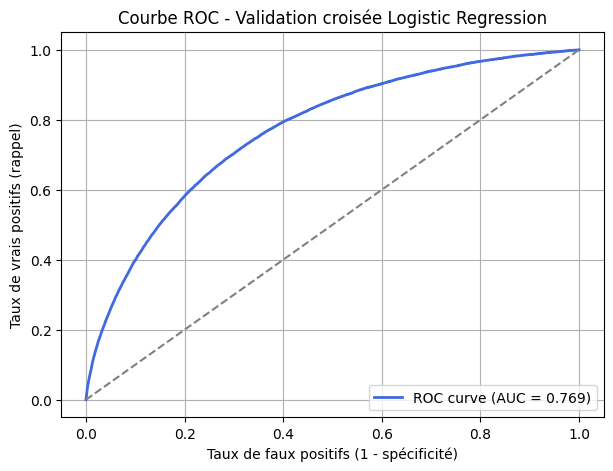

In [58]:
# y_proba_cv déjà calculé via cross_val_predict(method="predict_proba")
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)
auc_score = roc_auc_score(y, y_proba_cv)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de faux positifs (1 - spécificité)")
plt.ylabel("Taux de vrais positifs (rappel)")
plt.title("Courbe ROC - Validation croisée Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_LR.png")
plt.show()


* Le taux est cohérent, il est largement au-dessus d'un modèle aléatoire avec une performance 77%.

#### Enregistrement via MLFlow

In [60]:
projet_description = (
    "Résultats de la validation croisée sur LogisticRegression. Utilisation de plusieurs métriques (roc_auc/f1 etc.) par classe"
    "Résultats du classification report sur le fit. Mise en place de la visualisation de la ROC-AUC. Création du coût métier qui représente FN = 10 et FP = 1."
)

with mlflow.start_run(
    run_name="LogisticRegression_CV",
    tags={
        "Training Info": "LogisticRegression_CV",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_pred_cv)
    report_cv_dict = classification_report(y, y_pred_cv, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("roc_curve_LR.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry, optionnel) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="LogisticRegression_CV",
        registered_model_name="LogisticRegression_CV",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="LogisticRegression_CV", version=1, key="LogisticRegression_CV", value="...")
    client.update_model_version(
    name="LogisticRegression_CV",
    version=1,
    description="Résultats de la validation croisée sur LogisticRegression"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'LogisticRegression_CV'.
Created version '1' of model 'LogisticRegression_CV'.


### Modèle RandomForest avec hyperparamètres ajustés

In [63]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = RandomForestClassifier(
    random_state=42,
    max_depth = 12,
    n_estimators = 200,
    class_weight = 'balanced',
    min_samples_leaf = 4)
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv = validation_croisee(pipeline, X,y)

=== Résultats CV (train vs val) ===
roc_auc           : train 0.896 ± 0.001 vs val 0.751 ± 0.001
precision         : train 0.305 ± 0.002 vs val 0.207 ± 0.000
recall            : train 0.765 ± 0.002 vs val 0.498 ± 0.006
f1                : train 0.436 ± 0.002 vs val 0.292 ± 0.001
average_precision : train 0.483 ± 0.004 vs val 0.225 ± 0.002
balanced_accuracy : train 0.806 ± 0.001 vs val 0.665 ± 0.002

=== Classification Report — CROSS-VALIDATION ===
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89    282682
         1.0       0.21      0.50      0.29     24825

    accuracy                           0.81    307507
   macro avg       0.58      0.67      0.59    307507
weighted avg       0.89      0.81      0.84    307507


 Score métier global (10×FN + FP) = 172,102

=== Classification Report — ENTRAINEMENT ===
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89    282682
         1.0       0.

#### Graphique de la ROC AUC

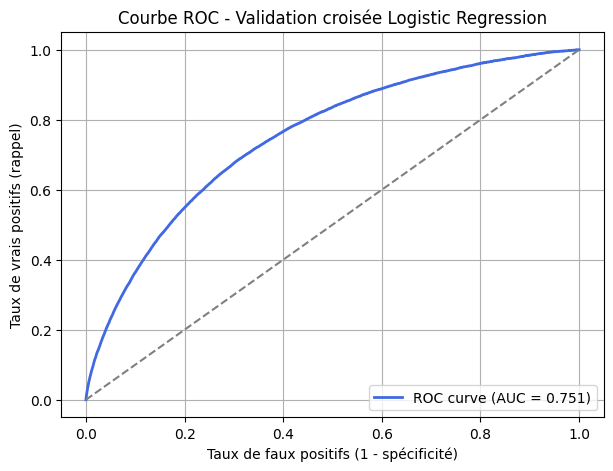

In [64]:
# y_proba_cv déjà calculé via cross_val_predict(method="predict_proba")
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)
auc_score = roc_auc_score(y, y_proba_cv)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de faux positifs (1 - spécificité)")
plt.ylabel("Taux de vrais positifs (rappel)")
plt.title("Courbe ROC - Validation croisée Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_RF.png")
plt.show()

#### Enregistrement via MLFlow

In [65]:
projet_description = (
    "Résultats de la validation croisée sur RandomForest. Utilisation de plusieurs métriques (roc_auc/f1 etc.) par classe"
    "Résultats du classification report sur le fit. Mise en place de la visualisation de la ROC-AUC. Création du coût métier qui représente FN = 10 et FP = 1."
)

with mlflow.start_run(
    run_name="RandomForest_CV",
    tags={
        "Training Info": "RandomForest_CV",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_pred_cv)
    report_cv_dict = classification_report(y, y_pred_cv, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("roc_curve_RF.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry, optionnel) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="RandomForest_CV",
        registered_model_name="RandomForest_CV",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="RandomForest_CV", version=1, key="RandomForest_CV", value="...")
    client.update_model_version(
    name="RandomForest_CV",
    version=1,
    description="Résultats de la validation croisée sur RandomForest"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'RandomForest_CV'.
Created version '1' of model 'RandomForest_CV'.


### Modèle XGBoost avec hyperparamètres ajustés

In [66]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = XGBClassifier(
    random_state=42,
    max_depth = 4,
    n_estimators = 300,
    learning_rate = 0.08,
    scale_pos_weight = 12,
    subsample = 0.8
    )
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv = validation_croisee(pipeline, X,y)

=== Résultats CV (train vs val) ===
roc_auc           : train 0.832 ± 0.000 vs val 0.781 ± 0.002
precision         : train 0.202 ± 0.001 vs val 0.182 ± 0.001
recall            : train 0.773 ± 0.001 vs val 0.695 ± 0.005
f1                : train 0.320 ± 0.001 vs val 0.289 ± 0.001
average_precision : train 0.340 ± 0.003 vs val 0.273 ± 0.002
balanced_accuracy : train 0.752 ± 0.000 vs val 0.711 ± 0.002

=== Classification Report — CROSS-VALIDATION ===
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83    282682
         1.0       0.18      0.70      0.29     24825

    accuracy                           0.72    307507
   macro avg       0.57      0.71      0.56    307507
weighted avg       0.90      0.72      0.78    307507


 Score métier global (10×FN + FP) = 153,103

=== Classification Report — ENTRAINEMENT ===
              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83    282682
         1.0       0.

#### Visualisation de la ROC AUC

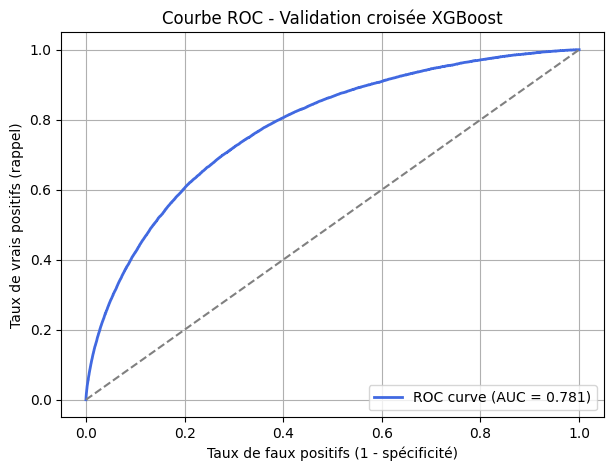

In [68]:
# y_proba_cv déjà calculé via cross_val_predict(method="predict_proba")
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)
auc_score = roc_auc_score(y, y_proba_cv)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de faux positifs (1 - spécificité)")
plt.ylabel("Taux de vrais positifs (rappel)")
plt.title("Courbe ROC - Validation croisée XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_XGB.png")
plt.show()

#### Enregistrement sous MLFlow

In [73]:
projet_description = (
    "Résultats de la validation croisée sur XGBoost. Utilisation de plusieurs métriques (roc_auc/f1 etc.) par classe"
    "Résultats du classification report sur le fit. Mise en place de la visualisation de la ROC-AUC. Création du coût métier qui représente FN = 10 et FP = 1."
)

with mlflow.start_run(
    run_name="XGBoost_CV",
    tags={
        "Training Info": "XGBoost_CV",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_pred_cv)
    report_cv_dict = classification_report(y, y_pred_cv, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("roc_curve_XGB.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry, optionnel) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="XGBoost_CV",
        registered_model_name="XGBoost_CV",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="XGBoost_CV", version=1, key="XGBoost_CV", value="...")
    client.update_model_version(
    name="XGBoost_CV",
    version=1,
    description="Résultats de la validation croisée sur XGBoost"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'XGBoost_CV'.
Created version '1' of model 'XGBoost_CV'.


### Modèle LightGBM avec hyperparamètres ajustés

In [74]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = lgb.LGBMClassifier(
    random_state=42,
    n_estimators = 300,
    num_leaves = 60,
    learning_rate = 0.05,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
    scale_pos_weight = 12,
    )
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv = validation_croisee(pipeline, X,y)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
=== Résultats CV (train vs val) ===
roc_auc           : train 0.913 ± 0.000 vs val 0.782 ± 0.001
precision         : train 0.266 ± 0.001 vs val 0.197 ± 0.001
recall            : train 0.886 ± 0.001 vs val 0.649 ± 0.005
f1                : train 0.409 ± 0.001 vs val 0.303 ± 0.002
average_precision : train 0.497 ± 0.001 vs val 0.272 ± 0.001
balanced_accuracy : train 0.836 ± 0.001 vs val 0.708 ± 0.002
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

=== Classification Report — CROSS-VALIDATION ===
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85    282682
         1.0       0.20      0.65      0.30     24825

    accuracy                           0.76    307507
   macro avg       0.58      0.71      0.58    307507
weighted avg       0.90      0.76      0.81    307507


 Score métier global (10×FN + FP) = 152,719
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

=== Classification Report — ENTRAINEMENT ===
              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86    282682
         1.0       0.24      0.84      0.37     24825

    accuracy                           0.77    307507
   macro avg       0.61      0.80      0.61    307507
weighted avg       0.92      0.77      0.82    307507



#### Visualisation de la ROC-AUC

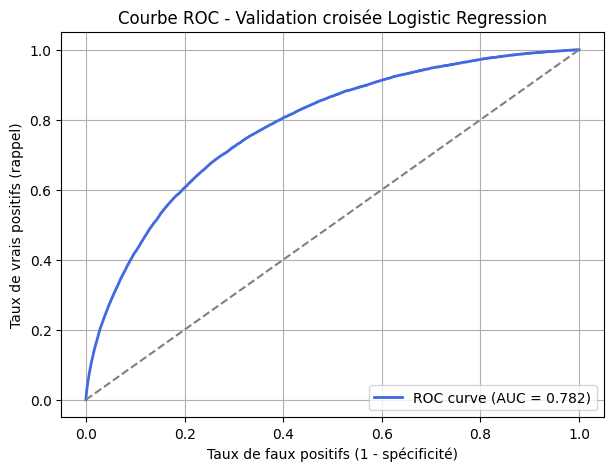

In [75]:
# y_proba_cv déjà calculé via cross_val_predict(method="predict_proba")
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)
auc_score = roc_auc_score(y, y_proba_cv)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de faux positifs (1 - spécificité)")
plt.ylabel("Taux de vrais positifs (rappel)")
plt.title("Courbe ROC - Validation croisée Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_LGB.png")
plt.show()

#### Enregistrement sous MLFlow

In [78]:
projet_description = (
    "Résultats de la validation croisée sur LightGBM. Utilisation de plusieurs métriques (roc_auc/f1 etc.) par classe"
    "Résultats du classification report sur le fit. Mise en place de la visualisation de la ROC-AUC. Création du coût métier qui représente FN = 10 et FP = 1."
)

with mlflow.start_run(
    run_name="LightGBM_CV",
    tags={
        "Training Info": "LightGBM_CV",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_pred_cv)
    report_cv_dict = classification_report(y, y_pred_cv, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("roc_curve_LGB.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry, optionnel) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="LightGBM_CV",
        registered_model_name="LightGBM_CV",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="LightGBM_CV", version=1, key="LightGBM_CV", value="...")
    client.update_model_version(
    name="LightGBM_CV",
    version=1,
    description="Résultats de la validation croisée sur LightGBM"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Successfully registered model 'LightGBM_CV'.
Created version '1' of model 'LightGBM_CV'.


### Comparaison des modèles directement sous MLFlow
* Les modèles qui ressortent en prenant en compte le meilleur score de la ROC AUC, et de quelques métriques clés comme le recall, sont les 2 modèles suivants :
    * XGBoost
    * LightGBM
* Mais nous allons chercher le seuil optimal en fonction du score métier pour tous les modèles afin de pouvoir mieux les comparer.
* L'idée du score métier est d'aller chercher le seuil de probabilité qui va chercher le coût métier le plus bas.

#### Fonction d'une validation croisée avec l'ajout du seuil optimal

In [81]:
# Fonction validation croisée
def validation_croisee_seuil_optimal(pipeline, X,y):
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_results = cross_validate(
        pipeline,
        X,y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
    )
    print("=== Résultats CV (train vs val) ===")
    for metric in scoring:
        tr = cv_results[f"train_{metric}"]
        te = cv_results[f"test_{metric}"]
        print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} "f"vs val {te.mean():.3f} ± {te.std():.3f}")

 # === Prédictions issues de la CV ===
    y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
    y_proba_cv = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method="predict_proba")[:, 1]

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    print(f"\n Score métier global (10×FN + FP) = {cout_metier:,}")

    # === Entraînement final ===
    pipeline.fit(X, y)
    y_pred_train = pipeline.predict(X)

    # --- Courbe du coût métier ---
    thresholds = np.linspace(0, 1, 101)
    costs = []

    for t in thresholds:
        y_pred_t = (y_proba_cv > t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred_t).ravel()
        cost = (fn * 10) + fp
        costs.append(cost)

    best_threshold = thresholds[np.argmin(costs)]
    best_cost = np.min(costs)

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, costs, color='steelblue', lw=2)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.2f}')
    plt.axvline(0.5, color='orange', linestyle=':', label='Seuil standard = 0.5')
    plt.title("Coût métier en fonction du seuil (validation croisée)")
    plt.xlabel("Seuil de décision (threshold)")
    plt.ylabel("Coût métier total (10×FN + FP)")
    plt.legend()
    plt.grid(True)
    plt.savefig("graph_seuil_optimal_LGB.png")
    plt.show()

    y_proba_test = (y_proba_cv >= best_threshold).astype(int)

    print("\n=== Classification Report — SEUIL OPTIMAL ===")
    print(classification_report(y, y_proba_test))
    print()

    # On renvoie tout ce qui servira après
    return cv_results, y_pred_cv, y_proba_cv, y_proba_test


### Modèle XGBoost avec seuil optimal

=== Résultats CV (train vs val) ===
roc_auc           : train 0.832 ± 0.000 vs val 0.781 ± 0.002
precision         : train 0.202 ± 0.001 vs val 0.182 ± 0.001
recall            : train 0.773 ± 0.001 vs val 0.695 ± 0.005
f1                : train 0.320 ± 0.001 vs val 0.289 ± 0.001
average_precision : train 0.340 ± 0.003 vs val 0.273 ± 0.002
balanced_accuracy : train 0.752 ± 0.000 vs val 0.711 ± 0.002

 Score métier global (10×FN + FP) = 153,103


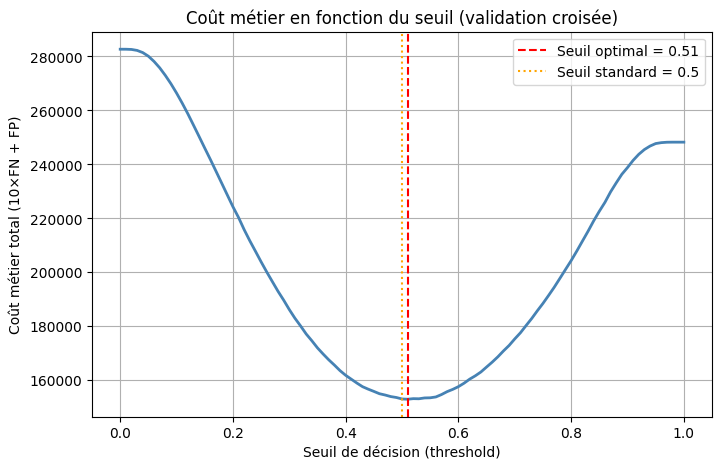


=== Classification Report — SEUIL OPTIMAL ===
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84    282682
         1.0       0.19      0.68      0.29     24825

    accuracy                           0.73    307507
   macro avg       0.57      0.71      0.56    307507
weighted avg       0.90      0.73      0.79    307507




In [82]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = XGBClassifier(
    random_state=42,
    max_depth = 4,
    n_estimators = 300,
    learning_rate = 0.08,
    scale_pos_weight = 12,
    subsample = 0.8
    )
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv, y_proba_test = validation_croisee_seuil_optimal(pipeline, X,y)

#### Enregistrement sous MLFlow

In [ ]:
projet_description = (
    "Nous cherchons ici à trouver le seuil optimal pour le modèle d'XGBoost en fonction du score métier"
)

with mlflow.start_run(
    run_name="XGBoost_seuil_optimal",
    tags={
        "Training Info": "XGBoost_seuil_optimal",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_proba_test)
    report_cv_dict = classification_report(y, y_proba_test, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("graph_seuil_optimal_LGB.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="XGBoost_seuil_optimal",
        registered_model_name="XGBoost_seuil_optimal",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="XGBoost_seuil_optimal", version=1, key="XGBoost_seuil_optimal", value="...")
    client.update_model_version(
    name="XGBoost_seuil_optimal",
    version=1,
    description="Résultats de la validation croisée sur XGBoost"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'XGBoost_seuil_optimal'.
Created version '1' of model 'XGBoost_seuil_optimal'.


### Modèle LightGM avec seuil optimal

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
=== Résultats CV (train vs val) ===
roc_auc           : train 0.913 ± 0.000 vs val 0.782 ± 0.001
precision         : train 0.266 ± 0.001 vs val 0.197 ± 0.001
recall            : train 0.886 ± 0.001 vs val 0.649 ± 0.005
f1                : train 0.409 ± 0.001 vs val 0.303 ± 0.002
average_precision : train 0.497 ± 0.001 vs val 0.272 ± 0.001
balanced_accuracy : train 0.836 ± 0.001 vs val 0.708 ± 0.002
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fract

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

 Score métier global (10×FN + FP) = 152,719
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100544 seconds.
You can set `force_row_wise=true` to remove the overhead

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


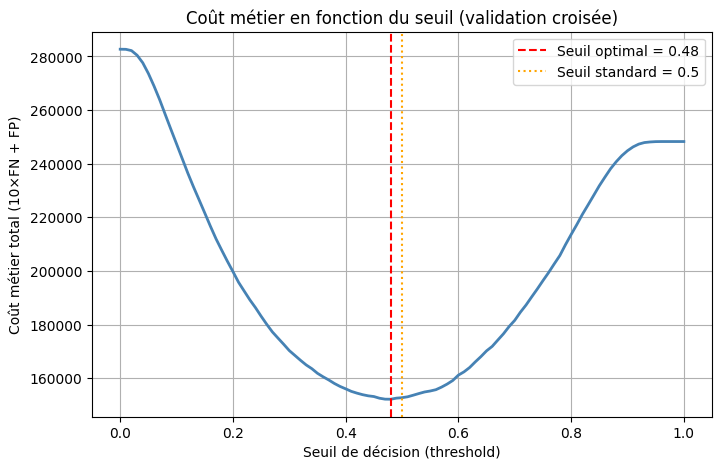


=== Classification Report — SEUIL OPTIMAL ===
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84    282682
         1.0       0.19      0.67      0.30     24825

    accuracy                           0.74    307507
   macro avg       0.58      0.71      0.57    307507
weighted avg       0.90      0.74      0.80    307507




In [85]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = lgb.LGBMClassifier(
    random_state=42,
    n_estimators = 300,
    num_leaves = 60,
    learning_rate = 0.05,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
    scale_pos_weight = 12,
    )
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv, y_proba_test = validation_croisee_seuil_optimal(pipeline, X,y)

#### Enregistrement sous MLFlow

In [86]:
projet_description = (
    "Nous cherchons ici à trouver le seuil optimal pour le modèle LightGBM en fonction du score métier"
)

with mlflow.start_run(
    run_name="LightGBM_seuil_optimal",
    tags={
        "Training Info": "LightGBM_seuil_optimal",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_proba_test)
    report_cv_dict = classification_report(y, y_proba_test, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("graph_seuil_optimal_LGB.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="LightGBM_seuil_optimal",
        registered_model_name="LightGBM_seuil_optimal",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="LightGBM_seuil_optimal", version=1, key="LightGBM_seuil_optimal", value="...")
    client.update_model_version(
    name="LightGBM_seuil_optimal",
    version=1,
    description="Résultats de la validation croisée sur LightGBM"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82103
[LightGB

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Successfully registered model 'LightGBM_seuil_optimal'.
Created version '1' of model 'LightGBM_seuil_optimal'.


### Modèle LogisticRegression avec seuil optimal

=== Résultats CV (train vs val) ===
roc_auc           : train 0.778 ± 0.001 vs val 0.769 ± 0.002
precision         : train 0.176 ± 0.001 vs val 0.172 ± 0.001
recall            : train 0.710 ± 0.001 vs val 0.697 ± 0.007
f1                : train 0.282 ± 0.001 vs val 0.277 ± 0.002
average_precision : train 0.256 ± 0.001 vs val 0.247 ± 0.003
balanced_accuracy : train 0.709 ± 0.001 vs val 0.702 ± 0.003

 Score métier global (10×FN + FP) = 158,193


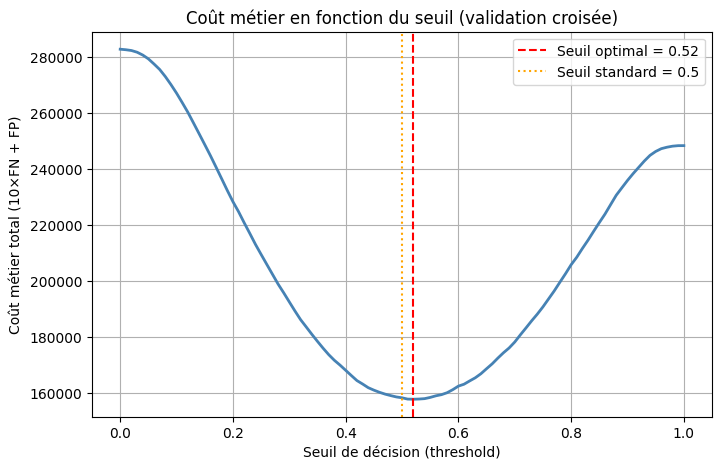


=== Classification Report — SEUIL OPTIMAL ===
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83    282682
         1.0       0.18      0.67      0.28     24825

    accuracy                           0.73    307507
   macro avg       0.57      0.70      0.56    307507
weighted avg       0.90      0.73      0.79    307507




In [87]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C = 1,
    class_weight = 'balanced',
    penalty = 'l2')
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv, y_proba_test = validation_croisee_seuil_optimal(pipeline, X,y)

#### Enregistrement sous MLFlow

In [88]:
projet_description = (
    "Nous cherchons ici à trouver le seuil optimal pour le modèle LogisticRegression en fonction du score métier"
)

with mlflow.start_run(
    run_name="LogisticRegression_seuil_optimal",
    tags={
        "Training Info": "LogisticRegression_seuil_optimal",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_proba_test)
    report_cv_dict = classification_report(y, y_proba_test, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("graph_seuil_optimal_LGB.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="LogisticRegression_seuil_optimal",
        registered_model_name="LogisticRegression_seuil_optimal",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="LogisticRegression_seuil_optimal", version=1, key="LogisticRegression_seuil_optimal", value="...")
    client.update_model_version(
    name="LogisticRegression_seuil_optimal",
    version=1,
    description="Résultats de la validation croisée sur LogisticRegression"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'LogisticRegression_seuil_optimal'.
Created version '1' of model 'LogisticRegression_seuil_optimal'.


### Modèle RandomForest avec le seuil optimal

=== Résultats CV (train vs val) ===
roc_auc           : train 0.896 ± 0.001 vs val 0.751 ± 0.001
precision         : train 0.305 ± 0.002 vs val 0.207 ± 0.000
recall            : train 0.765 ± 0.002 vs val 0.498 ± 0.006
f1                : train 0.436 ± 0.002 vs val 0.292 ± 0.001
average_precision : train 0.483 ± 0.004 vs val 0.225 ± 0.002
balanced_accuracy : train 0.806 ± 0.001 vs val 0.665 ± 0.002

 Score métier global (10×FN + FP) = 172,102


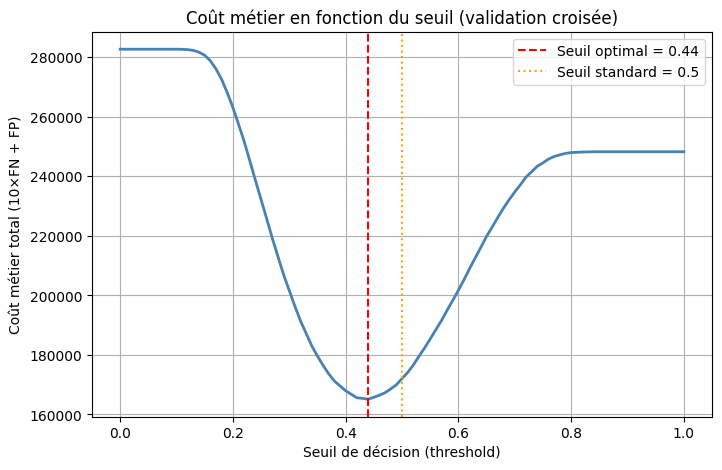


=== Classification Report — SEUIL OPTIMAL ===
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83    282682
         1.0       0.17      0.64      0.27     24825

    accuracy                           0.72    307507
   macro avg       0.57      0.69      0.55    307507
weighted avg       0.90      0.72      0.78    307507




In [89]:
preprocessor = save_preprocessor(cols_num,cols_encode)
model = RandomForestClassifier(
    random_state=42,
    max_depth = 12,
    n_estimators = 200,
    class_weight = 'balanced',
    min_samples_leaf = 4)
pipeline = save_pipeline(preprocessor,model)
cv_results, y_pred_cv, y_proba_cv, y_proba_test = validation_croisee_seuil_optimal(pipeline, X,y)

#### Enregistrement sous MLFlow

In [90]:
projet_description = (
    "Nous cherchons ici à trouver le seuil optimal pour le modèle RandomForest en fonction du score métier"
)

with mlflow.start_run(
    run_name="RandomForest_seuil_optimal",
    tags={
        "Training Info": "RandomForest_seuil_optimal",
        "mlflow.note.content": projet_description
    }
):
    
    X_sample = X.head(3).copy()
    y_sample = pipeline.predict(X.head(3))
    signature = infer_signature(X.head(3), y_sample)
    
    # === Rapport complet ===
    report_cv = classification_report(y, y_proba_test)
    report_cv_dict = classification_report(y, y_proba_test, output_dict=True)

    # === Log des métriques PAR CLASSE ===
    for classe in ["0.0", "1.0"]:
        mlflow.log_metric(f"precision_class_{classe}", report_cv_dict[classe]["precision"])
        mlflow.log_metric(f"recall_class_{classe}", report_cv_dict[classe]["recall"])
        mlflow.log_metric(f"f1_class_{classe}", report_cv_dict[classe]["f1-score"])

    # === Log des résultats des métriques de la validation croisée ===
    scoring = ['roc_auc','precision','recall','f1','average_precision','balanced_accuracy']
    for metrics in scoring:
        mlflow.log_metric(f"cv_val_{metrics}", cv_results[f"test_{metrics}"].mean())
        mlflow.log_metric(f"cv_val_{metrics}_std", cv_results[f"test_{metrics}"].std())

    # === Log des paramètres utilisées ===
    mlflow.log_params(pipeline.named_steps["model"].get_params())

    # === Score métier ===
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    cout_metier = (fn * 10) + fp
    mlflow.log_metric("score_metier", cout_metier)

    # === Enregistrement de la visualisation de la ROC-AUC ===
    mlflow.log_artifact("graph_seuil_optimal_LGB.png")

    # === Log du rapport complet (artefact texte) ===
    mlflow.log_text(report_cv, "classification_report_cv.txt")

    # === Log du modèle complet (pour le registry) ===
    pipeline.fit(X, y)
    mlflow.sklearn.log_model(
        pipeline,
        name="RandomForest_seuil_optimal",
        registered_model_name="RandomForest_seuil_optimal",
        input_example=X_sample,
        signature=signature)
    
    # === Enregistrement du model registry ===
    client.set_model_version_tag(name="RandomForest_seuil_optimal", version=1, key="RandomForest_seuil_optimal", value="...")
    client.update_model_version(
    name="RandomForest_seuil_optimal",
    version=1,
    description="Résultats de la validation croisée sur RandomForest"
)

/Users/florianschorer/Library/Caches/pypoetry/virtualenvs/modele-scoring-mlflow-N-Hr5ii3-py3.13/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'RandomForest_seuil_optimal'.
Created version '1' of model 'RandomForest_seuil_optimal'.
